In [1]:
%cd ..

/home/vagrant/Development/advent-of-code-2022/python


In [2]:
from inspect import cleandoc
from aocd import get_data
import ipytest
ipytest.autoconfig()

data = get_data(year=2022, day=22)

In [3]:
example = cleandoc("""
            ...#    
            .#..    
            #...    
            ....    
    ...#.......#    
    ........#...    
    ..#....#....    
    ..........#.    
            ...#....
            .....#..
            .#......
            ......#.

    10R5L5R10L4R5L5
    """)

In [12]:
from aoc22.geometry import Direction, Rotation, Point, Rectangle
from dataclasses import dataclass
from enum import Enum, auto
from functools import cached_property
from math import sqrt
from parsec import eof, generate, many1, regex, sepBy, string
from typing import Callable, ClassVar, Self

class Tile(Enum):
    OPEN = auto()
    WALL = auto()
    
@dataclass
class Board:
    tiles: dict[Point, Tile]
    
    @cached_property
    def face_size(self) -> int:
        return int(sqrt(len(self.tiles) // 6))
    
    @cached_property
    def face_bounds(self) -> list[Rectangle]:
        f = self.face_size
        return [
            Rectangle.square(Point(f, 0), f),
            Rectangle.square(Point(2*f, 0), f),
            Rectangle.square(Point(f, f), f),
            Rectangle.square(Point(0, 2*f), f),
            Rectangle.square(Point(f, 2*f), f),
            Rectangle.square(Point(0, 3*f), f),
        ]
    
    def face_of(self, p: Point) -> int:
        return next(i for i, r in enumerate(self.face_bounds, start=1) if p in r)

@dataclass
class Move:
    steps: int
    
    def execute(self, board: Board, position: Point, direction: Direction):
        for i in range(self.steps):
            new_position = position + direction
            if new_position not in board.tiles:
                match direction:
                    case Direction.U:
                        new_position = Point(position.x, max(p.y for p in board.tiles if p.x == position.x))
                    case Direction.D:
                        new_position = Point(position.x, min(p.y for p in board.tiles if p.x == position.x))
                    case Direction.L:
                        new_position = Point(max(p.x for p in board.tiles if p.y == position.y), position.y)
                    case Direction.R:
                        new_position = Point(min(p.x for p in board.tiles if p.y == position.y), position.y)
                
            if board.tiles[new_position] is Tile.WALL:
                break
            else:
                position = new_position
        return position, direction
    
    def execute2(self, board: Board, position: Point, direction: Direction):
        for i in range(self.steps):
            new_position = position + direction
            new_direction = direction
            if new_position not in board.tiles:
                f = board.face_size

                match (direction, board.face_of(position)):
                    case (Direction.U, 1):
                        c = Point(2*f, 0)
                        t = Point(-2*f, 4*f)
                        r = Rotation.CLOCKWISE
                    case (Direction.U, 2):
                        c = Point(0, 0)
                        t = Point(-2*f, 4*f-1)
                        r = Rotation.ID
                    case (Direction.U, 4):
                        c = Point(f, 2*f)
                        t = Point(0, 0)
                        r = Rotation.CLOCKWISE
                    case (Direction.D, 2):
                        c = Point(2*f-1, f-1)
                        t = Point(0, 0)
                        r = Rotation.CLOCKWISE
                    case (Direction.D, 5):
                        c = Point(f-1, 3*f-1)
                        t = Point(0, 0)
                        r = Rotation.CLOCKWISE
                    case (Direction.D, 6):
                        c = Point(0, 0)
                        t = Point(2*f, -4*f+1)
                        r = Rotation.ID
                    case (Direction.L, 1):
                        c = Point(f, f-1)
                        t = Point(-f, f+1)
                        r = Rotation.HALF_TURN
                    case (Direction.L, 3):
                        c = Point(f, 2*f)
                        t = Point(0, 0)
                        r = Rotation.COUNTERCLOCKWISE
                    case (Direction.L, 4):
                        c = Point(0, 2*f)
                        t = Point(f, -f-1)
                        r = Rotation.HALF_TURN
                    case (Direction.L, 6):
                        c = Point(0, 4*f)
                        t = Point(2*f, -4*f)
                        r = Rotation.COUNTERCLOCKWISE
                    case (Direction.R, 2):
                        c = Point(3*f-1, f-1)
                        t = Point(-f, f+1)
                        r = Rotation.HALF_TURN
                    case (Direction.R, 3):
                        c = Point(2*f-1, f-1)
                        t = Point(0, 0)
                        r = Rotation.COUNTERCLOCKWISE
                    case (Direction.R, 5):
                        c = Point(2*f-1, 2*f)
                        t = Point(f, -f-1)
                        r = Rotation.HALF_TURN
                    case (Direction.R, 6):
                        c = Point(f-1, 3*f-1)
                        t = Point(0, 0)
                        r = Rotation.COUNTERCLOCKWISE
                    case (d, face):
                        print(position, direction, face)
                    
                new_position = r * (position - c) + c + t
                new_direction = r * direction
            
            if new_position not in board.tiles:
                print(position, direction, "->", new_position, new_direction)
                
            if board.tiles[new_position] is Tile.WALL:
                break
            else:
                position = new_position
                direction = new_direction
        return position, direction

@dataclass
class Turn:
    value: Rotation
    
    def execute(self, board: Board, position: Point, direction: Direction):
        return position, self.value * direction
    
    def execute2(self, board: Board, position: Point, direction: Direction):
        return self.execute(board, position, direction)

@dataclass
class Puzzle:
    board: Board
    path: list[Move|Turn]
    
    DIRECTION_VALUES: ClassVar = {
        Direction.R: 0,
        Direction.D: 1,
        Direction.L: 2,
        Direction.U: 3,
    }
    
    @staticmethod
    def encode(position: Point, direction: Direction) -> int:
        return (
            1000 * (position.y + 1)
            + 4 * (position.x + 1)
            + Puzzle.DIRECTION_VALUES[direction]
        )
    
    def final_password(self) -> int:
        position = Point(2 * self.board.face_size, 0)
        direction = Direction.R
        
        for step in self.path:
            position, direction = step.execute(self.board, position, direction)
        
        return Puzzle.encode(position, direction)
    
    def final_password2(self) -> int:
        position = Point(self.board.face_size, 0)
        direction = Direction.R
        
        for step in self.path:
            position, direction = step.execute2(self.board, position, direction)
        
        return Puzzle.encode(position, direction)


tile = (
    string(" ").parsecmap(lambda _: None)
    | string(".").parsecmap(lambda _: Tile.OPEN)
    | string("#").parsecmap(lambda _: Tile.WALL)
)


board = sepBy(many1(tile), string("\n")).parsecmap(lambda lines: Board({Point(x, y): t for y, line in enumerate(lines) for x, t in enumerate(line) if t}))
number = regex("\d+").parsecmap(int)
move = number.parsecmap(lambda n: Move(n))
turn = (
    string("L").parsecmap(lambda _: Turn(Rotation.COUNTERCLOCKWISE))
    | string("R").parsecmap(lambda _: Turn(Rotation.CLOCKWISE))
)
path = many1(move | turn)

@generate
def puzzle():
    b = yield board
    yield string("\n\n")
    p = yield path
    return Puzzle(b, p)
    

example_puzzle = puzzle.parse(example)
data_puzzle = puzzle.parse(data)

In [79]:
%%ipytest
import pytest

@pytest.mark.parametrize("position, direction, expected_position, expected_direction", [
    (Point(8, 0), Direction.U, Point(8, 0), Direction.U),
    (Point(9, 0), Direction.U, Point(2, 4), Direction.D),
    (Point(10, 0), Direction.U, Point(1, 4), Direction.D),
    (Point(2, 4), Direction.U, Point(9, 0), Direction.D),
    (Point(1, 4), Direction.U, Point(10, 0), Direction.D),
    
    (Point(4, 4), Direction.U, Point(8, 0), Direction.R),
    (Point(5, 4), Direction.U, Point(8, 1), Direction.R),
    (Point(6, 4), Direction.U, Point(6, 4), Direction.U),
    
    (Point(12, 8), Direction.U, Point(11, 7), Direction.L),
    (Point(13, 8), Direction.U, Point(11, 6), Direction.L),
    (Point(15, 8), Direction.U, Point(15, 8), Direction.U),
    
    (Point(0, 7), Direction.D, Point(11, 11), Direction.U),
    (Point(1, 7), Direction.D, Point(10, 11), Direction.U),
    (Point(2, 7), Direction.D, Point(9, 11), Direction.U),

    (Point(9, 11), Direction.D, Point(2, 7), Direction.U),
    (Point(10, 11), Direction.D, Point(1, 7), Direction.U),
    (Point(11, 11), Direction.D, Point(0, 7), Direction.U),

    (Point(12, 11), Direction.D, Point(0, 7), Direction.R),
    (Point(13, 11), Direction.D, Point(0, 6), Direction.R),
    (Point(15, 11), Direction.D, Point(0, 4), Direction.R),

    (Point(4, 7), Direction.D, Point(8, 11), Direction.R),
    (Point(5, 7), Direction.D, Point(8, 10), Direction.R),
    
    (Point(0, 7), Direction.L, Point(12, 11), Direction.U),
    (Point(0, 6), Direction.L, Point(13, 11), Direction.U),
    (Point(0, 4), Direction.L, Point(15, 11), Direction.U),
    
    (Point(8, 11), Direction.L, Point(4, 7), Direction.U),
    (Point(8, 10), Direction.L, Point(5, 7), Direction.U),
    
    (Point(11, 1), Direction.R, Point(15, 10), Direction.L),

    (Point(11, 7), Direction.R, Point(12, 8), Direction.D),
    (Point(11, 6), Direction.R, Point(13, 8), Direction.D),
    
    (Point(15, 10), Direction.R, Point(11, 1), Direction.L),
])
def test_move_execute2(position, direction, expected_position, expected_direction):
    actual = Move(1).execute2(example_puzzle.board, position, direction)
    assert (expected_position, expected_direction) == actual


...............................                                                              [100%]
31 passed in 0.11s


## Part 1

In [6]:
example_puzzle.final_password()

6032

In [7]:
puzzle.parse(data).final_password()

75388

## Part 2

In [76]:
example_puzzle.final_password2()

5031

In [85]:
data_puzzle.board.tiles[Point(118, 50)]

KeyError: Point(118, 50)

In [13]:
data_puzzle.final_password2()

182170

In [9]:
p = Point(87, 0)
c = Point(100, 0)
Rotation.CLOCKWISE * (p - c) + c + Point(-100, 200)

Point(0, 187)

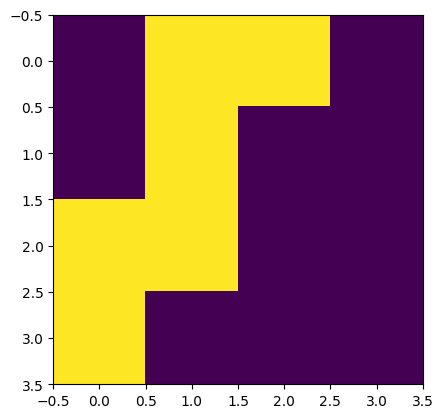

In [16]:
from matplotlib.pyplot import imshow
f = data_puzzle.board.face_size
imshow([[Point(i*f, j*f) in data_puzzle.board.tiles for i in range(4)] for j in range(4)])

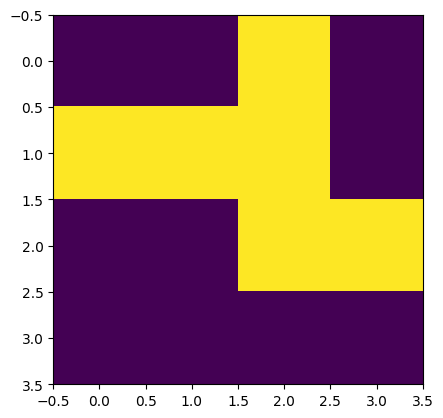

In [18]:
f = example_puzzle.board.face_size
imshow([[Point(i*f, j*f) in example_puzzle.board.tiles for i in range(4)] for j in range(4)])